# Build a Traffic Sign Recognition Classifier
##### - by NK Zou

---

### Rubric Points

### 1- Files Submitted
* Traffic_Sign_Classifier.ipynb  
* Traffic_Sign_Classifier.html  
* train.p & test.p (download link on step 0)  
* 6 test images in images folder  
* lenet.meta, lenet.index, lenet.data  
* signnames.csv  
* writeup.md  
  
### 2- Dataset Exploration
2.1- Dataset Summary (step 1.1)  
2.2- Exploratory Visualization (step 1.2)  
  
### 3- Design and Test a Model Architecture
3.1- Preprocessing (step 2.1)  
3.2- Model Architecture (step 2.2)  
3.3- Model Training (step 2.3)  
3.4- Solution Design  (writeup.md)
  
### 4- Test a Model on New Images
4.1- Acquiring New Images (step 3.1 & 3.2)  
4.2- Performance on New Images (step 3.3)  
4.3- Model Certainty - Softmax Probabilities (step 3.3)  
  
---

### Step 0: Load The Data
down load the dataset from https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip

In [1]:
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

### Step 1: Dataset Summary & Exploration
#### 1.1- Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

n_train = np.shape(x_train)[0]
n_test = np.shape(x_test)[0]
image_shape = np.shape(x_train)[1:3]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


##### 1.2- Include an exploratory visualization of the dataset

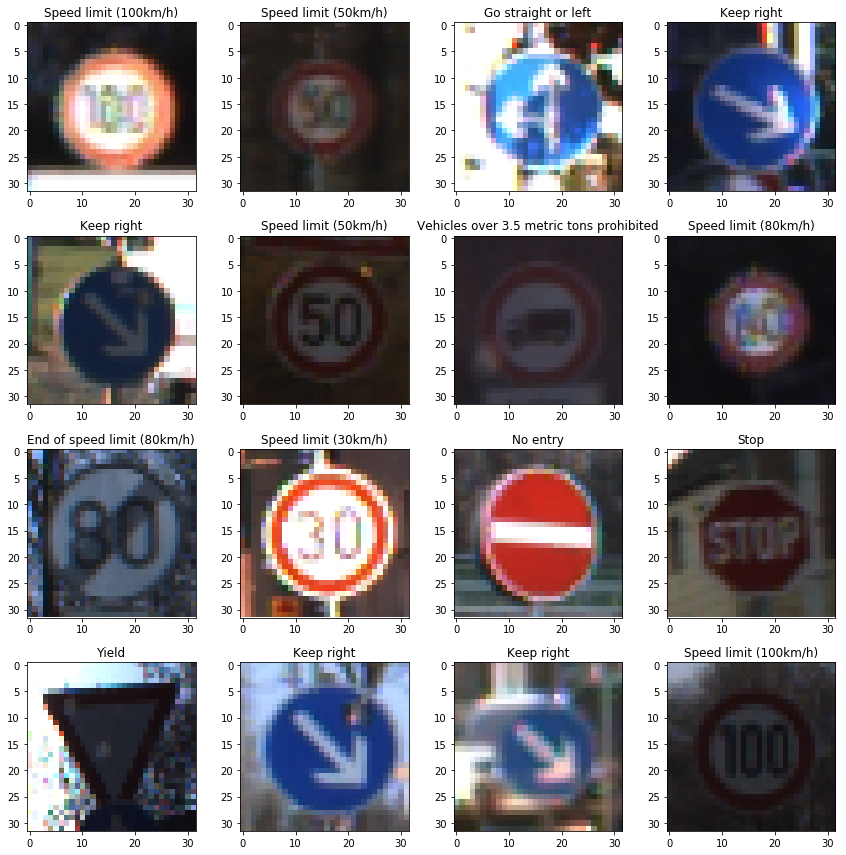

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

signnames = pd.read_csv('signnames.csv')

### Creat a label set as dictionary, extract elements from signnames and mapping Signname to ClassId in label_set
label_set = dict()
for ele in signnames.iterrows():  # iterate every row
    r = ele[1]
    ClassId = r['ClassId']
    SignName = r['SignName']
    label_set[ClassId] = SignName
    
### Random pickup feature from train set
sample = np.random.randint(0, n_train, 16)
sample_images = x_train[sample]
sample_labels = [label_set[s] for s in  y_train[sample]]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()
fig.tight_layout()
for axis, image, label in zip(axes, sample_images, sample_labels):
    axis.imshow(image)
    axis.set_title(label)

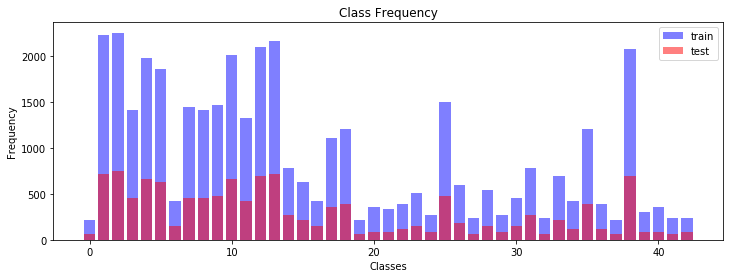

In [4]:
### Count train data and test data
unique1, counts1 = np.unique(y_train, return_counts=True)
dict_classes_count1 = dict(zip(unique1, counts1))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_classes_count2 = dict(zip(unique2, counts2))

### Combine bar of train and bar of test into figure
plt.figure(figsize=(12, 4))
plt.bar(range(len(dict_classes_count1)), dict_classes_count1.values(), width=0.8, label="train", color="b", alpha=0.5)
plt.bar(range(len(dict_classes_count2)), dict_classes_count2.values(), width=0.8, label="test", color="r", alpha=0.5)
plt.legend(loc="best")
plt.title('Class Frequency')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

### Step 2: Design and Test a Model Architecture
##### 2.1- Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

normalized_x_train = []
normalized_y_train = []
all_images = dict()
images = dict()
for i, (image, label) in enumerate(zip(x_train, y_train)):
    if label not in all_images:
        all_images[label] = []
    zeros = np.zeros((32,32,3))
    normalized_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_x_train.append(normalized_image)
    normalized_y_train.append(label)
    images[label] = normalized_image
    all_images[label].append(normalized_image)
x_train, y_train = shuffle(normalized_x_train, normalized_y_train)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

##### 2.2- Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

### Train function
def LeNet(x):    
### Parameters for convolution
    mu = 0
    sigma = 0.1
### 5 layers,w=weight, b=bias, 32x32x3->28x28x6->14x14x6, ->10x10x16->5x5x16->(flatten:1x1x400)400, ->120, ->84, ->43
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    fc0 = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1 = tf.nn.relu(fc1)  
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2 = tf.nn.relu(fc2)

    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits

### No train function, it is accuracy function to compute accuracy of samples
def evaluate(x_data, y_data):
    num_samples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_samples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_samples

##### 2.3- Train, Validate and Test the Model

In [7]:
### Features and labels, colored image =(32,32,3), ,mono image = (32,32,1)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Hyperparameter
epochs = 66
batch_size = 128
keep_prob = tf.placeholder(tf.float32)

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=10000, decay_rate=0.96, staircase=True)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation,global_step)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Train and save model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(str(len(x_train)) + ' examples will be trained in ' + str(epochs) + ' epochs.' )
    for i in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, len(x_train), batch_size):
            end = offset + batch_size
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]   
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
    ### Compute validation accuracy
        validation_accuracy = evaluate(x_validation, y_validation)
        print('EPOCH {} '.format(i+1) +': Validation Accuracy = {:.3f}'.format(validation_accuracy))
    ### Save model    
    saver.save(sess, './lenet')
    print("Model saved")
    
### Test model
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

31367 examples will be trained in 66 epochs.
EPOCH 1 : Validation Accuracy = 0.593
EPOCH 2 : Validation Accuracy = 0.789
EPOCH 3 : Validation Accuracy = 0.880
EPOCH 4 : Validation Accuracy = 0.908
EPOCH 5 : Validation Accuracy = 0.932
EPOCH 6 : Validation Accuracy = 0.942
EPOCH 7 : Validation Accuracy = 0.957
EPOCH 8 : Validation Accuracy = 0.958
EPOCH 9 : Validation Accuracy = 0.966
EPOCH 10 : Validation Accuracy = 0.962
EPOCH 11 : Validation Accuracy = 0.971
EPOCH 12 : Validation Accuracy = 0.975
EPOCH 13 : Validation Accuracy = 0.975
EPOCH 14 : Validation Accuracy = 0.975
EPOCH 15 : Validation Accuracy = 0.977
EPOCH 16 : Validation Accuracy = 0.979
EPOCH 17 : Validation Accuracy = 0.980
EPOCH 18 : Validation Accuracy = 0.980
EPOCH 19 : Validation Accuracy = 0.982
EPOCH 20 : Validation Accuracy = 0.984
EPOCH 21 : Validation Accuracy = 0.982
EPOCH 22 : Validation Accuracy = 0.984
EPOCH 23 : Validation Accuracy = 0.983
EPOCH 24 : Validation Accuracy = 0.986
EPOCH 25 : Validation Accura

### Step 3: Test a Model on New Images
##### 3.1- Load and preprocess the Images

In [8]:
import glob
import cv2
import numpy as np

### Resize image
resized_images = []
for i in glob.glob('images/*.jpg'):
    image = cv2.imread(i)
    resized_image = cv2.resize(image, (32, 32))
    resized_images.append(resized_image)
risized_images = np.asarray(resized_images)
print('Shape of resized images is: ' + str(np.shape(resized_images)))

### Normalizate image, don't gray image in here since we need colored image to feed LeNet
normalized_images = (np.array(resized_images) - 128.0)/128.0
print('Shape of normalzed images is: ' + str(np.shape(normalized_images)))

Shape of resized images is: (6, 32, 32, 3)
Shape of normalzed images is: (6, 32, 32, 3)


##### 3.2- Plot test image

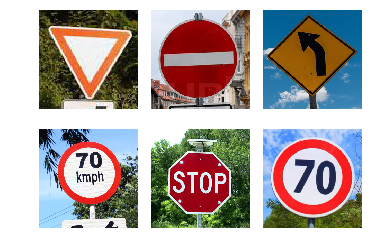

In [9]:
fig, axs = plt.subplots(2,3, figsize=(6, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, img in enumerate(glob.glob('images/*jpg')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [10]:
extral_labels = [13, 9, 34, 4, 14, 4]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    extra_accuracy = evaluate(normalized_images, extral_labels)
    print("Extral Test Accuracy = {:.3f}".format(extra_accuracy))

Extral Test Accuracy = 0.333


##### 3.3- Predict the Sign Type for Each Image

In [11]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')  
    softmax_logits = tf.nn.softmax(logits)
    top_k = tf.nn.top_k(softmax_logits, k=5)
    softmax_logits = sess.run(softmax_logits, feed_dict={x: normalized_images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: normalized_images, keep_prob: 1.0})
    top_5 = sess.run(top_k, feed_dict={x:normalized_images, keep_prob:1.0})
    print(top_5)

TopKV2(values=array([[  1.00000000e+00,   1.24215376e-22,   1.59013168e-24,
          1.20665722e-24,   8.78510386e-30],
       [  6.25817716e-01,   3.67688775e-01,   4.07407153e-03,
          1.28507265e-03,   1.13442738e-03],
       [  9.63527501e-01,   3.58430780e-02,   6.22194086e-04,
          7.25212340e-06,   4.16346128e-15],
       [  1.00000000e+00,   2.12922217e-22,   2.82545458e-23,
          2.37808036e-25,   1.51064783e-26],
       [  9.99986053e-01,   1.12328498e-05,   2.75537809e-06,
          5.60708757e-10,   4.36586260e-14],
       [  8.35400224e-01,   1.60037920e-01,   4.30551590e-03,
          1.64207639e-04,   6.19985876e-05]], dtype=float32), indices=array([[13, 15,  9, 33, 35],
       [33, 40, 36, 37, 34],
       [40, 37, 33, 39, 34],
       [12, 41,  9, 38, 10],
       [40, 34, 37, 38, 33],
       [ 4, 39, 22, 33, 29]], dtype=int32))


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


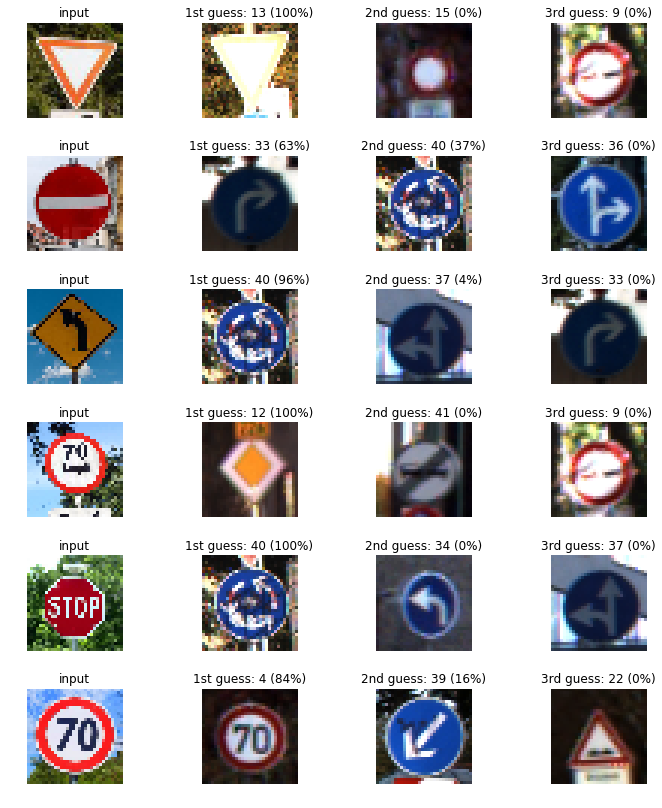

In [12]:
### Predicting probability

fig, axs = plt.subplots(len(resized_images),4, figsize=(12, 14))
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()
for i, image in enumerate(resized_images):
    axs[4*i].axis('off')
    axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[4*i].set_title('input')
    guess1 = top_5[1][i][0]
    index1 = np.argwhere(y_validation == guess1)[0]
    axs[4*i+1].axis('off')
    axs[4*i+1].imshow(x_validation[index1].squeeze(), cmap='gray')
    axs[4*i+1].set_title('1st guess: {} ({:.0f}%)'.format(guess1, 100*top_5[0][i][0]))
    guess2 = top_5[1][i][1]
    index2 = np.argwhere(y_validation == guess2)[0]
    axs[4*i+2].axis('off')
    axs[4*i+2].imshow(x_validation[index2].squeeze(), cmap='gray')
    axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*top_5[0][i][1]))
    guess3 = top_5[1][i][2]
    index3 = np.argwhere(y_validation == guess3)[0]
    axs[4*i+3].axis('off')
    axs[4*i+3].imshow(x_validation[index3].squeeze(), cmap='gray')
    axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*top_5[0][i][2]))

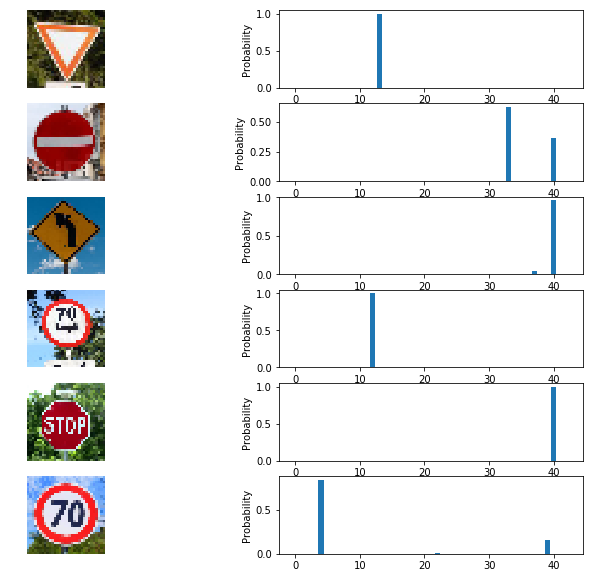

In [16]:
### Predicting probability

fig, axs = plt.subplots(6,2, figsize=(12, 10))
axs = axs.ravel()

for i in range(len(softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(resized_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Probability')